In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
import src.config as config

In [3]:
os.environ["HOPSWORKS_API_KEY"] = "jaThBXjYztKj0Mr2.jvcnZsSjp04pK6c4uuSoK7LtNHJOe9EFRZtegX2KXmxrHAv6MGSPiIY6iODgbe8S"
api_key = os.getenv("HOPSWORKS_API_KEY")

import os
from dotenv import load_dotenv

# Load .env file
load_dotenv("hopsworks.env")  # Make sure this file exists

# Print the API key (for debugging)
api_key = os.getenv("HOPSWORKS_API_KEY")
if api_key:
    print("✅ API Key Loaded Successfully!")
else:
    print("❌ API Key Not Found. Check .env file.")

import os
import hopsworks
api_key = os.getenv("HOPSWORKS_API_KEY")
project = hopsworks.login(api_key_value=api_key)
print("Logged into Hopsworks:", project.name)

feature_store = project.get_feature_store()

FEATURE_GROUP_NAME = "time_series_hourly_feature_group"
FEATURE_GROUP_VERSION = 1

feature_group = feature_store.get_feature_group(
    name=FEATURE_GROUP_NAME,
    version=FEATURE_GROUP_VERSION,
)

✅ API Key Loaded Successfully!
2025-03-04 18:03:37,154 INFO: Initializing external client
2025-03-04 18:03:37,154 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-03-04 18:03:37,799 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1214665
Logged into Hopsworks: nyc_taxi_proj


In [5]:
query = feature_group.select_all()  # This gets the query
df = query.read()  # Execute the query and load it into a DataFrame


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (6.66s) 


In [6]:
print("Unique years in dataset:", df["pickup_hour"].dt.year.unique())


Unique years in dataset: [2023 2025]


In [7]:
print(feature_group)


In [8]:
print(feature_group.schema)


[Feature('pickup_hour', 'timestamp', None, True, False, None, None, 1402010), Feature('pickup_location_id', 'int', None, True, False, None, None, 1402010), Feature('rides', 'int', None, False, False, None, None, 1402010)]


In [6]:
"""
import hopsworks

project = hopsworks.login(
    project=config.HOPSWORKS_PROJECT_NAME, api_key_value=config.HOPSWORKS_API_KEY
)

feature_store = project.get_feature_store()
feature_group = feature_store.get_feature_group(
    name=config.FEATURE_GROUP_NAME,
    version=config.FEATURE_GROUP_VERSION
)
"""

'\nimport hopsworks\n\nproject = hopsworks.login(\n    project=config.HOPSWORKS_PROJECT_NAME, api_key_value=config.HOPSWORKS_API_KEY\n)\n\nfeature_store = project.get_feature_store()\nfeature_group = feature_store.get_feature_group(\n    name=config.FEATURE_GROUP_NAME,\n    version=config.FEATURE_GROUP_VERSION\n)\n'

In [9]:
# Create a feature view if it doesn't already exist
try:
    feature_store.create_feature_view(
        name=config.FEATURE_VIEW_NAME,
        version=config.FEATURE_VIEW_VERSION,
        query=feature_group.select_all(),
    )
    print(f"Feature view '{config.FEATURE_VIEW_NAME}' (version {config.FEATURE_VIEW_VERSION}) created successfully.")
except Exception as e:
    print(f"Error creating feature view: {e}")

# Retrieve the feature view
try:
    feature_view = feature_store.get_feature_view(
        name=config.FEATURE_VIEW_NAME,
        version=config.FEATURE_VIEW_VERSION,
    )
    print(f"Feature view '{config.FEATURE_VIEW_NAME}' (version {config.FEATURE_VIEW_VERSION}) retrieved successfully.")
except Exception as e:
    print(f"Error retrieving feature view: {e}")

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1214665/fs/1202293/fv/time_series_hourly_feature_view/version/1
Feature view 'time_series_hourly_feature_view' (version 1) created successfully.
Feature view 'time_series_hourly_feature_view' (version 1) retrieved successfully.


In [10]:
ts_data, _ = feature_view.training_data(
    description="Time-series hourly taxi rides"
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (7.90s) 
2025-03-04 18:05:55,034 WARNING: VersionWarning: Incremented version to `1`.



In [11]:
ts_data = ts_data.sort_values(["pickup_location_id", "pickup_hour"]).reset_index(drop=True)

In [12]:
# import pandas as pd

# # Ensure pickup_hour is in datetime format
# ts_data["pickup_hour"] = pd.to_datetime(ts_data["pickup_hour"])

# # Check if it's already timezone-aware
# if ts_data["pickup_hour"].dt.tz is None:
#     # If not localized, first localize to UTC
#     ts_data["pickup_hour"] = ts_data["pickup_hour"].dt.tz_localize("UTC")

# # Convert to EST
# ts_data["pickup_hour_est"] = ts_data["pickup_hour"].dt.tz_convert("America/New_York")


In [16]:
ts_data.tail()

,pickup_hour,pickup_location_id,rides
2452291,2025-03-04 17:00:00+00:00,263,117
2452292,2025-03-04 18:00:00+00:00,263,132
2452293,2025-03-04 19:00:00+00:00,263,99
2452294,2025-03-04 20:00:00+00:00,263,86
2452295,2025-03-04 21:00:00+00:00,263,76


In [17]:
ts_data["pickup_hour"].min()

'2023-01-01 00:00:00+00:00'

In [19]:
ts_data["pickup_hour"].max()

'2025-03-04 21:00:00+00:00'

In [20]:
ts_data_copy = ts_data.copy()

In [21]:
import pandas as pd
ts_data["pickup_hour"] = pd.to_datetime(ts_data["pickup_hour"], errors="coerce")

In [22]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2452296 entries, 0 to 2452295
Data columns (total 3 columns):
 #   Column              Dtype              
---  ------              -----              
 0   pickup_hour         datetime64[ns, UTC]
 1   pickup_location_id  int32              
 2   rides               int32              
dtypes: datetime64[ns, UTC](1), int32(2)
memory usage: 37.4 MB


In [23]:
ts_data["pickup_hour"] = ts_data["pickup_hour"].dt.tz_localize(None)  # Remove timezone

In [24]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2452296 entries, 0 to 2452295
Data columns (total 3 columns):
 #   Column              Dtype         
---  ------              -----         
 0   pickup_hour         datetime64[ns]
 1   pickup_location_id  int32         
 2   rides               int32         
dtypes: datetime64[ns](1), int32(2)
memory usage: 37.4 MB


In [25]:
ts_data["year_month"] = ts_data["pickup_hour"].dt.to_period("M")  # Year-Month format

In [26]:
ts_data

,pickup_hour,pickup_location_id,rides,year_month
0,2023-01-01 00:00:00,2,0,2023-01
1,2023-01-01 01:00:00,2,0,2023-01
2,2023-01-01 02:00:00,2,0,2023-01
3,2023-01-01 03:00:00,2,0,2023-01
4,2023-01-01 04:00:00,2,0,2023-01
...,...,...,...,...
2452291,2025-03-04 17:00:00,263,117,2025-03
2452292,2025-03-04 18:00:00,263,132,2025-03
2452293,2025-03-04 19:00:00,263,99,2025-03
2452294,2025-03-04 20:00:00,263,86,2025-03


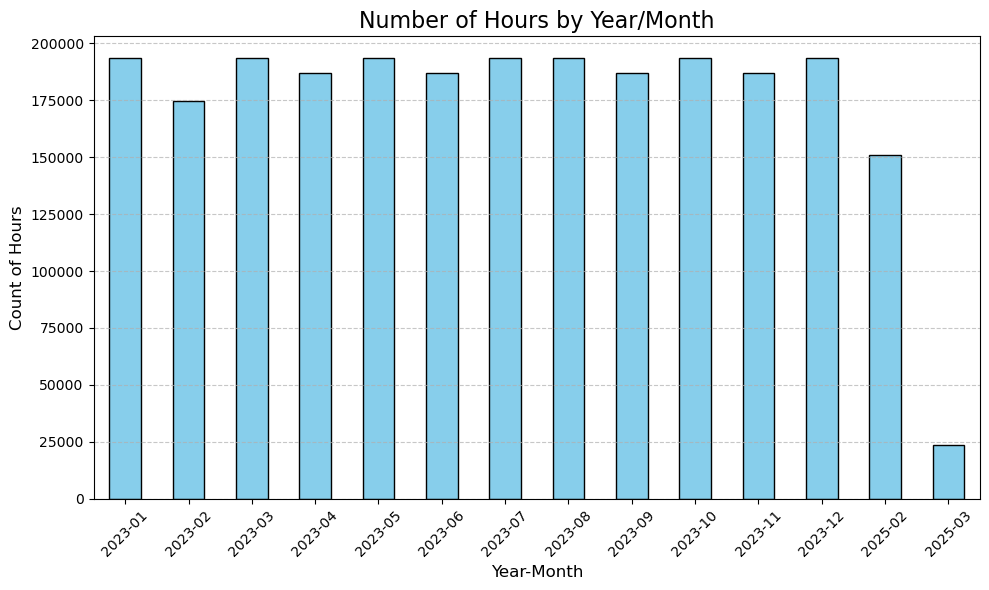

In [27]:
import matplotlib.pyplot as plt
# Group by year_month and count
hour_counts = ts_data.groupby("year_month").size()
# Plot the data
ax = hour_counts.plot(kind="bar", figsize=(10, 6), color="skyblue", edgecolor="black")  # Use 'ax' to store the plot object
ax.set_title("Number of Hours by Year/Month", fontsize=16)
ax.set_xlabel("Year-Month", fontsize=12)
ax.set_ylabel("Count of Hours", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [28]:
print("Min Date:", ts_data["pickup_hour"].min())
print("Max Date:", ts_data["pickup_hour"].max())


Min Date: 2023-01-01 00:00:00
Max Date: 2025-03-04 21:00:00


In [29]:
ts_data.head()      

,pickup_hour,pickup_location_id,rides,year_month
0,2023-01-01 00:00:00,2,0,2023-01
1,2023-01-01 01:00:00,2,0,2023-01
2,2023-01-01 02:00:00,2,0,2023-01
3,2023-01-01 03:00:00,2,0,2023-01
4,2023-01-01 04:00:00,2,0,2023-01


In [30]:
gte = ts_data["year_month"] >= pd.Period("2023-01", freq="M")
lte = ts_data["year_month"] <= pd.Period("2023-12", freq="M")
cond = gte & lte
filtered_data = ts_data[cond].reset_index(drop=True)

In [31]:
filtered_data.drop(columns=["year_month"], inplace=True) 

In [32]:
filtered_data.shape

(2277600, 3)

In [33]:
ts_data = filtered_data

In [34]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2277600 entries, 0 to 2277599
Data columns (total 3 columns):
 #   Column              Dtype         
---  ------              -----         
 0   pickup_hour         datetime64[ns]
 1   pickup_location_id  int32         
 2   rides               int32         
dtypes: datetime64[ns](1), int32(2)
memory usage: 34.8 MB


In [35]:
ts_data.head()["pickup_hour"].values

array(['2023-01-01T00:00:00.000000000', '2023-01-01T01:00:00.000000000',
       '2023-01-01T02:00:00.000000000', '2023-01-01T03:00:00.000000000',
       '2023-01-01T04:00:00.000000000'], dtype='datetime64[ns]')

In [36]:
from src.data_utils import transform_ts_data_info_features_and_target

features, targets = transform_ts_data_info_features_and_target(ts_data, window_size=24*28, step_size=23)

In [38]:
features.sort_values(["pickup_location_id", "pickup_hour"])

,rides_t-672,rides_t-671,rides_t-670,rides_t-669,rides_t-668,rides_t-667,rides_t-666,rides_t-665,rides_t-664,rides_t-663,...,rides_t-8,rides_t-7,rides_t-6,rides_t-5,rides_t-4,rides_t-3,rides_t-2,rides_t-1,pickup_hour,pickup_location_id
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,2023-01-29 00:00:00,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-01-29 23:00:00,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-01-30 22:00:00,2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-01-31 21:00:00,2
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-02-01 20:00:00,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91515,110,115,101,125,129,137,109,137,132,89,...,8,38,37,68,74,98,85,89,2023-12-27 13:00:00,263
91516,104,109,89,133,130,143,165,103,106,111,...,8,14,30,34,49,76,96,88,2023-12-28 12:00:00,263
91517,100,114,110,117,134,130,188,250,173,142,...,9,8,11,38,46,55,73,73,2023-12-29 11:00:00,263
91518,151,148,147,134,119,137,124,126,160,205,...,36,13,14,16,20,25,42,54,2023-12-30 10:00:00,263


In [39]:
features[features["pickup_location_id"] == 2]

,rides_t-672,rides_t-671,rides_t-670,rides_t-669,rides_t-668,rides_t-667,rides_t-666,rides_t-665,rides_t-664,rides_t-663,...,rides_t-8,rides_t-7,rides_t-6,rides_t-5,rides_t-4,rides_t-3,rides_t-2,rides_t-1,pickup_hour,pickup_location_id
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,2023-01-29 00:00:00,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-01-29 23:00:00,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-01-30 22:00:00,2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-01-31 21:00:00,2
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-02-01 20:00:00,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-12-27 13:00:00,2
348,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-12-28 12:00:00,2
349,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-12-29 11:00:00,2
350,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-12-30 10:00:00,2


In [40]:
features_copy = features.copy()

In [41]:
features_targets = features.copy()
features_targets["target"] = targets

features_targets.shape

(91520, 675)

In [42]:
from datetime import datetime, timedelta  
import pandas as pd  
from src.data_utils import split_time_series_data  

# Define the cutoff date as 28 days before today  
cutoff_date = pd.Timestamp(datetime.now() - timedelta(days=28))  
# # Convert the cutoff date to a string in a specific format (e.g., 'YYYY-MM-DD')  
# cutoff_date_str = cutoff_date.strftime('%Y-%m-%d')
# # Print the string representation of the cutoff date  
# print(f"Cutoff date as string: {cutoff_date_str}")
cutoff_date

Timestamp('2025-02-04 18:20:35.004052')

In [43]:
X_train, y_train, X_test, y_test = split_time_series_data(
    features_targets,
    cutoff_date=cutoff_date,
    target_column="target"
)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(91520, 674)
(91520,)
(0, 674)
(0,)


In [44]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91520 entries, 0 to 91519
Columns: 674 entries, rides_t-672 to pickup_location_id
dtypes: datetime64[ns](1), int32(1), int64(672)
memory usage: 470.3 MB


In [45]:
from src.pipeline_utils import get_pipeline
pipeline = get_pipeline()

In [46]:
pipeline.fit(features, targets)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.126080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 171646
[LightGBM] [Info] Number of data points in the train set: 91520, number of used features: 675
[LightGBM] [Info] Start training from score 16.630299


Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function average_rides_last_4_weeks at 0x323453560>)),
                ('temporalfeatureengineer', TemporalFeatureEngineer()),
                ('lgbmregressor', LGBMRegressor())])

In [47]:
from sklearn.metrics import mean_absolute_error
predictions = pipeline.predict(features)

In [48]:
predictions

array([ 0.16632143,  0.16632143,  0.16632143, ..., 83.42269769,
       75.76323756, 60.66289631])

In [49]:
test_mae = mean_absolute_error(targets, predictions)
print(f"{test_mae:.4f}")

1.9355


In [50]:
import joblib  


# Save the pipeline  
joblib.dump(pipeline, config.MODELS_DIR / "lgb_model.pkl")

['/Users/sharmilamanoj/Documents/sp25_taxi-main/models/lgb_model.pkl']

In [51]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

input_schema = Schema(features)
output_schema = Schema(targets)
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

In [53]:
model_registry = project.get_model_registry()

model = model_registry.sklearn.create_model(
    name="taxi_demand_predictor_next_hour",
    metrics={"test_mae": test_mae},
    description="LightGBM regressor",
    input_example=features.sample(),
    model_schema=model_schema,
    #include_files=["src/", "requirements.txt"]  # Include directories and files
)
# https://community.hopsworks.ai/t/attributeerror-windowspath-object-has-no-attribute-startswith/1003
# model.save(config.MODELS_DIR / 'lgb_model.pkl')
model.save('/Users/sharmilamanoj/Documents/sp25_taxi-main/models/lgb_model.pkl')


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/317901 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/2049 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/48705 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1214665/models/taxi_demand_predictor_next_hour/1


Model(name: 'taxi_demand_predictor_next_hour', version: 1)

In [54]:
from src.inference import load_model_from_registry

model = load_model_from_registry()

2025-03-04 18:23:01,683 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-03-04 18:23:01,684 INFO: Initializing external client
2025-03-04 18:23:01,685 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-03-04 18:23:02,307 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1214665


In [55]:
from src.inference import get_model_predictions

In [56]:
preds = get_model_predictions(model, features_copy)

In [57]:
preds

,pickup_location_id,predicted_demand
0,2,0.0
1,2,0.0
2,2,0.0
3,2,0.0
4,2,0.0
...,...,...
91515,263,86.0
91516,263,95.0
91517,263,83.0
91518,263,76.0


In [58]:
test_mae = mean_absolute_error(targets, preds["predicted_demand"])
print(f"{test_mae:.4f}")

1.8374
